In [1]:
1+1

2

In [ ]:
include("cosmology.jl")
using PyPlot, ODE, Dierckx, Roots
set_bigfloat_precision(128);

In [3]:
function _sigrp(rp, R)
    c1 = sqrt(R*R./rp./rp-1.0)
    1./rp.*atan(c1)
end
function _dmdrp(rp, R)
    rp.*_sigrp(rp,R)
end
function _mrp(rp, R)
    quadgk(rp->_dmdrp(rp, R), 0.0, rp)[1]
end
function mrp(M0, R, rp)
    f = M0/_mrp(R, R)
    _mrp(rp, R)*f
end

mrp (generic function with 1 method)

In [6]:
mrp(200.0, 200.0, 4)/4

1.560795992514947

In [28]:
rg(m) = 2.0.*m.*G./C./C
function miso(M0, R, r)
    M0.*r./R
end
rgiso(M0, R, r) = rg(miso(M0, R, r))

function direct_lens(M0, R, b, N=100)
    # only inside the halo
    f=3M0*G/C/C/R
    ω=sqrt(1.0-f)
    ϕm = 1/ω*acos(b/R)+π/2
    ϕl = linspace(ϕm,π,N) 
    function f(ϕ, y)
        (u, v) = y
        u_prime = v
        v_prime = 3*M0*G/C/C/R*u-u
        [u_prime; v_prime]    
    end
    const u0 = 1.0/R   
    const du0 = -ω/b*sin(ω*ϕl[1]-π/2*ω)
    start = [u0; du0];
    
    ϕ, y = ode45(f, start, ϕl, abstol=1.0e-10, reltol=1.0e-12);
    u = map(y -> y[1], y);
    du = map(y -> y[2], y);

    x = [Float64(v) for v in -cos(ϕ)./u]
    y = [Float64(v) for v in sin(ϕ)./u]
    x,y, u[end], du[end]
end

function direct_lens3(M0, R, b, u0, du0, N=100)
    # hitting the halo but defined outside too
    ϕl = linspace(0, π, N)    
    function f(ϕ, y)
        (u, v) = y
        u_prime = v
        v_prime = 3*M0*G/C/C/R*u-u
        [u_prime; v_prime]    
    end
    start = [u0; du0];
    
    ϕ, y = ode45(f, start, ϕl, abstol=1.0e-13, reltol=1.0e-14);
    u = map(y -> y[1], y);
    
    x = [Float64(v) for v in -cos(ϕ)./u]
    y = [Float64(v) for v in sin(ϕ)./u]        
    x,y
end

function direct_lens5(M0, R, b, N=100)
    # mising the halo
    rg = M0*G/C/C*2
    function f(ϕ, y)
        (u, v) = y
        u_prime = v
        v_prime = 3/2*rg*u*u-u
        [u_prime; v_prime]    
    end
    const u0 = 1.0/R
    const tgθ0 = b/R
    const du0 = 1.0/(R*abs(tgθ0))
    start = [u0; du0];
    ϕl = linspace(0, π, N)        
    ϕ, y = ode45(f, start, ϕl, abstol=1.0e-13, reltol=1.0e-14);
    u = map(y -> y[1], y);
    x = [Float64(v) for v in -cos(ϕ)./u]
    y = [Float64(v) for v in sin(ϕ)./u]        
    x,y
end

function analytic_lens(M0, R, rmin, N=100)
    @show f=3M0*G/C/C/R
    ω=sqrt(1.0-f)

    @show ϕm = 1/ω*acos(rmin/R)+π/2
    ϕl = linspace(ϕm,π-ϕm,N)
    
    u = 1/b*cos(ω*ϕl-π/2*ω)
    
    x = [Float64(v) for v in cos(ϕl)./u]
    y = [Float64(v) for v in sin(ϕl)./u]        
    x,y
end

function thin_lens(M0p, R, b, N=100)
    const tgθ = b/R
    const θ=atan(tgθ)
    #const nθ = θ-2.0*   frg(b)   /b
    const nθ = θ-4*M0p*G/C/C   /b
    const tgnθ = tan(nθ)
    nx = -b/tgnθ
    if nθ>0.0
        nx = R
    end
    
    lx = linspace(0.0,1.0,div(N,2)).^3
    x = [-reverse(lx)*R; lx*nx]
    y = zeros(length(x))
    for i in 1:length(x)
        y[i] = if x[i]<0.0
            tgθ*(x[i]+R)
        else
            b+tgnθ*x[i]
        end
    end
    x, y
end

function thin_lens2(M0p, R, b, N=100)
    const tgθ = b/R
    const θ=atan(tgθ)
    #const nθ = θ-2.0*   frg(b)   /b
    const deflection_angle = 4*M0p*G/C/C   /b
    const nθ = θ-deflection_angle
    const tgnθ = tan(nθ)
    nx = -b/tgnθ
    if nθ>0.0
        nx = R
    end
    
    lx = linspace(0.0,1.0,div(N,2)).^3
    x = [-reverse(lx)*R; lx*nx]
    y = zeros(length(x))
    for i in 1:length(x)
        y[i] = if x[i]<0.0
            tgθ*(x[i]+R)
        else
            b+tgnθ*x[i]
        end
    end
    x, y, deflection_angle
end


function mfac(M0, R, rp, N, minr=1.0e-3)
    tot = 0.0
    ptot = 0.0
    @inbounds for i in 1:N
        x=rand()*rp+minr
        y=rand()*rp+minr
        z=rand()*R+minr
        r=sqrt(x*x+y*y+z*z)
        r>R && continue
        pr = sqrt(x*x+y*y)
        pr > rp && continue
        ρ=1/r/r
        ptot += ρ
        if r <= rp
            tot += ρ
        end
    end
    ptot/tot
end


mfac (generic function with 2 methods)

In [29]:
# Mmw = big"200.0";
# Rmw = big"200.0";
# b= big"4.0";

Mmw = 200.0;
Rmw = 200.0;
b= 4.0;

In [30]:
ax,ay = analytic_lens(Mmw, Rmw, b, 170);

f = ((((3M0) * G) / C) / C) / R = 1.4355555667711075e-6
ϕm = (1 / ω) * acos(rmin / R) + π / 2 = 3.121592433143794


In [31]:
dx,dy,u0,du0 = direct_lens(Mmw, Rmw, b, 100000);
dx,dy = direct_lens3(Mmw, Rmw, b, u0, -du0, 100000);

In [32]:
f = mfac(Mmw, Rmw, b, 100000000, 1.0e-2)

1.5786275119825333

In [33]:
M0p = Mmw*b/Rmw*1.560795992514947 #*f
tx,ty = thin_lens(M0p, dx[end], b, 1000);

In [34]:
dx[end]

3.5477249950747658e6

In [35]:
dx[1]

-3.547724984594522e6

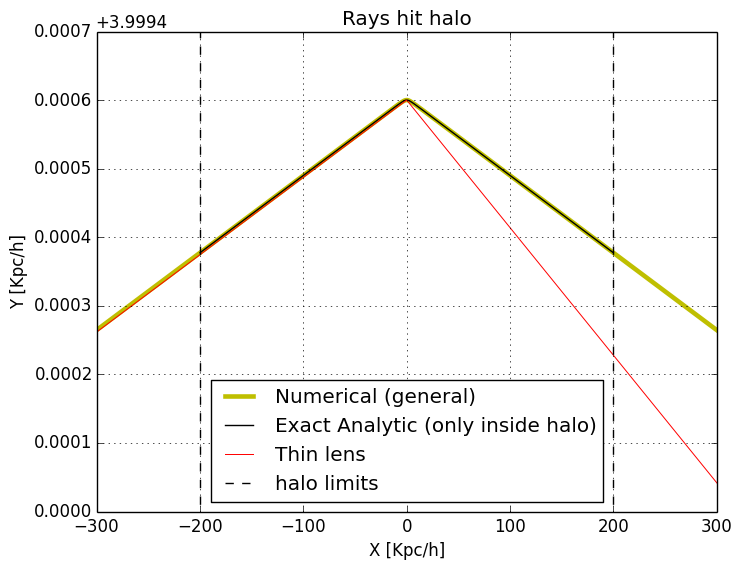

PyObject <matplotlib.text.Text object at 0x31e808210>

In [36]:
hold(false)
plot(dx, dy, "-y", ms=0.0, lw=3.3)
hold(true)
plot(ax, ay, "-k", ms=5.5, lw=1.01)
plot(tx, ty, "-r", ms=5.5, lw=0.71)
plot([-200, -200],[0, 5],"--k")
plot([+200, +200],[0, 5],"--k")
hold(false)
grid(true)
xlim(-300,300)
ylim(3.9994,4.0001)
legend(["Numerical (general)","Exact Analytic (only inside halo)","Thin lens","halo limits"],"bottom left")
xlabel("X [Kpc/h]")
ylabel("Y [Kpc/h]")
title("Rays hit halo")

In [37]:
g1= abs(atan(4/dx[1]))+abs(atan(4/dx[end]))

2.254966217200923e-6

In [38]:
g2= abs(atan(4/tx[1]))+abs(atan(4/tx[end]))

2.987479167531824e-6

In [39]:
(g2-g1)/g1

0.3248443124084427

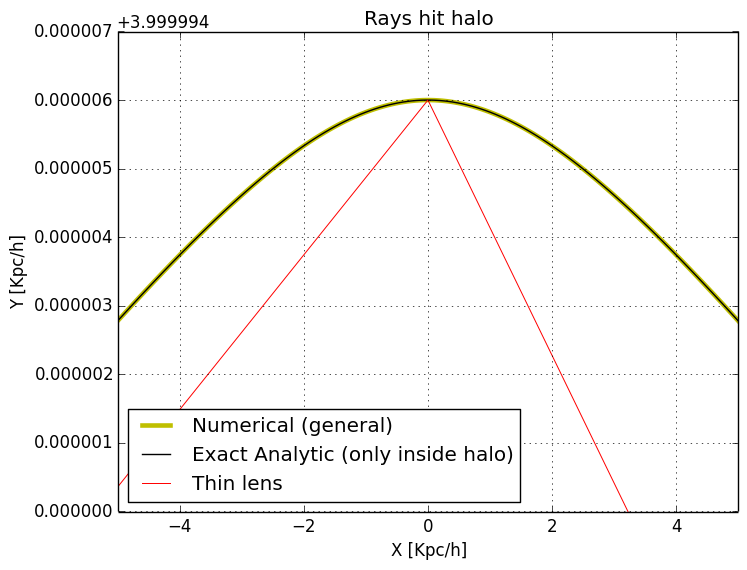

PyObject <matplotlib.text.Text object at 0x31f24efd0>

In [40]:
hold(false)
plot(dx[1:500:end], dy[1:500:end], "-y", ms=2.5, lw=3.3)
hold(true)
plot(ax, ay, "-k", ms=5.5, lw=1.01)
plot(tx, ty, "-r", ms=5.5, lw=0.71)
plot([-200, -200],[0, 5],"--k")
plot([+200, +200],[0, 5],"--k")
hold(false)
grid(true)
xlim(-5,5)
ylim(3.999994,4.000001)
legend(["Numerical (general)","Exact Analytic (only inside halo)","Thin lens"],"bottom left")
xlabel("X [Kpc/h]")
ylabel("Y [Kpc/h]")
title("Rays hit halo")

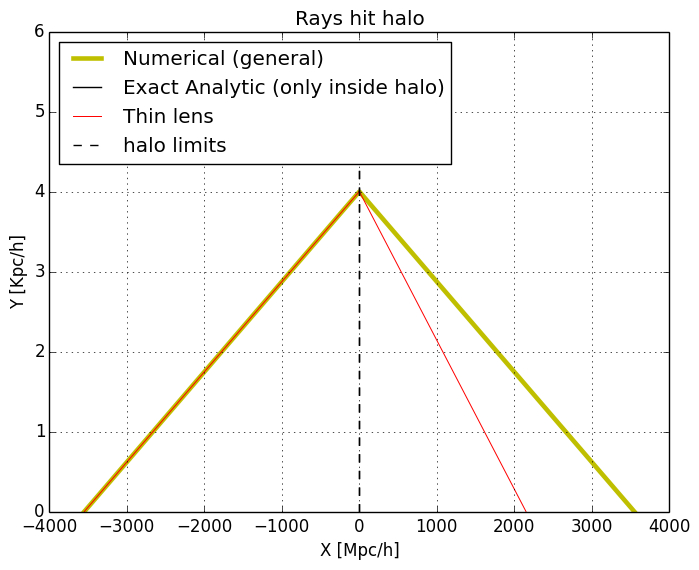

PyObject <matplotlib.text.Text object at 0x31ff1bc90>

In [41]:
hold(false)
plot(dx[1:end]/1e3, dy[1:end], "-y", ms=2.5, lw=3.3)
hold(true)
plot(ax/1e3, ay, "-k", ms=5.5, lw=1.01)
plot(tx/1e3, ty, "-r", ms=5.5, lw=0.71)
plot([-200, -200]/1e3,[0, 5],"--k")
plot([+200, +200]/1e3,[0, 5],"--k")
hold(false)
grid(true)
#xlim(-5,5)
ylim(0,6)
legend(["Numerical (general)","Exact Analytic (only inside halo)","Thin lens","halo limits"],loc=2)
xlabel("X [Mpc/h]")
ylabel("Y [Kpc/h]")
title("Rays hit halo")

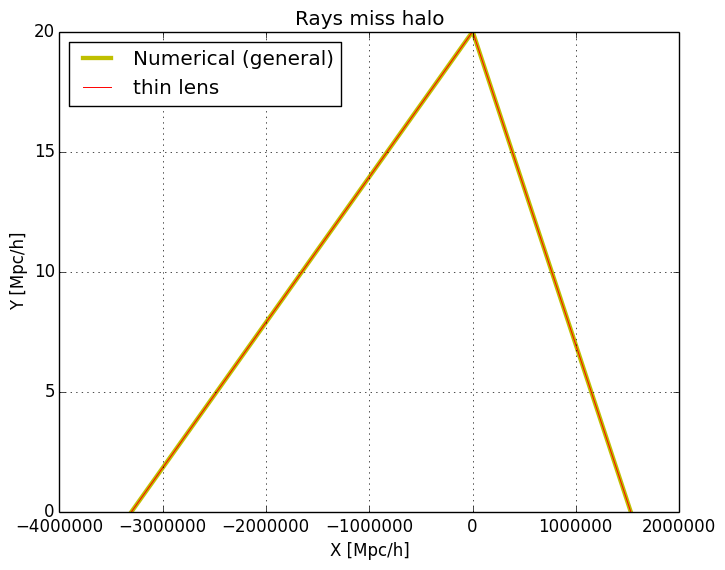

PyObject <matplotlib.text.Text object at 0x31ffd91d0>

In [42]:
tx,ty = thin_lens(200.0, 3.3e6, 20.0, 1000);
dx, dy = direct_lens5(200.0, 3.3e6, 20.0, 1000)
plot(dx,dy,"y-", lw=3.1)
hold(true)
plot(tx,ty, "-r", lw=0.7)
hold(false)
grid(true)
xlabel("X [Mpc/h]")
ylabel("Y [Mpc/h]")
legend(["Numerical (general)", "thin lens"], loc=2)
title("Rays miss halo")

In [43]:
tds = Float64[]
dds = Float64[]
bs = Float64[]
for b in 0.1:0.01:5.7
    push!(bs, b)
    M0p= mrp(200.0, 200.0, b)
    tx,ty, da = thin_lens2(M0p, 3.05e6, b, 1000);
    push!(tds, da) #abs(atan(b/tx[1]))+abs(atan(b/tx[end])))
    dx, dy = direct_lens5(200.0*b./200.0, 3.05e6, b, 1000)
    push!(dds, abs(atan(b/dx[1]))+abs(atan(b/dx[end])))
end

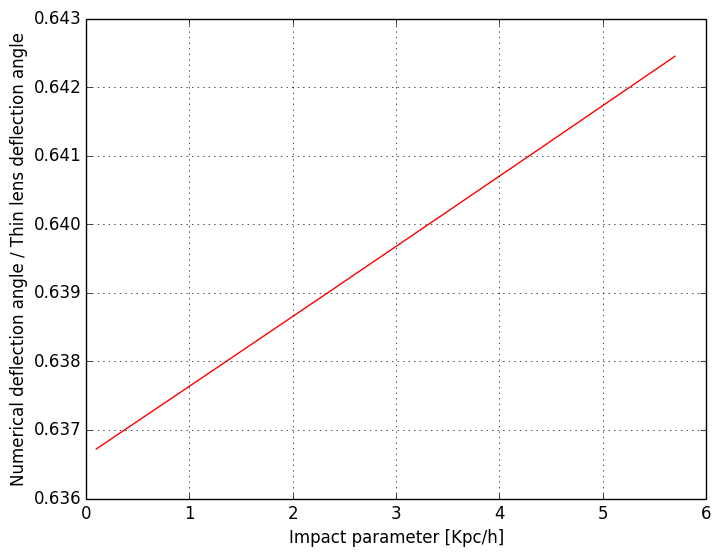

PyObject <matplotlib.text.Text object at 0x31ffec410>

In [44]:
plot(bs, dds./tds,"-r")
grid(true)
xlabel("Impact parameter [Kpc/h]")
ylabel("Numerical deflection angle / Thin lens deflection angle")

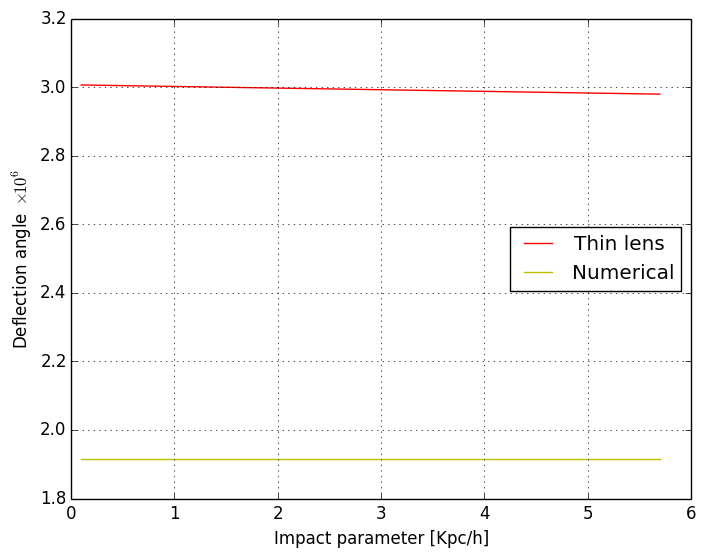

PyObject <matplotlib.legend.Legend object at 0x31f8cf190>

In [45]:
plot(bs, tds*1e6,"-r",lw=1)
hold(true)
plot(bs, dds*1e6,"-y",lw=1)
hold(false)
grid(true)
xlabel("Impact parameter [Kpc/h]")
ylabel("Deflection angle \$\\times 10^6\$")
legend(["Thin lens", "Numerical"], loc=5)